In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
from utils import trim_state_dict_name, Flatten
from torch.autograd import Variable

# pretrained 3D resnet from https://github.com/Tencent/MedicalNet
from resnet3D import resnet50

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.benchmark = True

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE

In [4]:
def get_feature_extractor():
    model = resnet50(shortcut_type='B')
    model.conv_seg = nn.Sequential(nn.AdaptiveAvgPool3d((1, 1, 1)),
                                   Flatten()) # (N, 512)
    # download pretrained weight from https://drive.google.com/file/d/13tnSvXY7oDIEloNFiGTsjUIYfS3g3BfG/view?usp=sharing
    ckpt = torch.load("../gnn_shared/ckpt/pretrain/resnet_50.pth")
    ckpt = trim_state_dict_name(ckpt["state_dict"])
    model.load_state_dict(ckpt)
    model = nn.DataParallel(model).cuda()
    model.eval()
    print("Feature extractor weights loaded")
    return model

model = get_feature_extractor()

Feature extractor weights loaded


In [5]:
save_step = 80000 #
batch_size = 2
img_size = 256
num_samples=512
dims=2048

## 1. Extract features for HA-GAN

In [3]:
from Model_Alpha_GAN_256_SN_GN_v4_4_eval import Generator, Encoder, Sub_Encoder

latent_dim = 1024
basename = "256_1024_Alpha_SN_v4plus_4_l1_GN_threshold_600"

In [6]:
G = Generator(noise=latent_dim, mode="eval")

ckpt_path = "./checkpoint/"+basename+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)

print(save_step, "step weights loaded.")
del ckpt

G = nn.DataParallel(G).cuda()
G.eval()

torch.cuda.empty_cache()

80000 step weights loaded.


In [7]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    with torch.no_grad():
        noise = torch.randn((batch_size, latent_dim)).cuda()
        x_rand = G(noise, 0) # dumb index 0, not used
        x_rand = x_rand.detach()
        #x_rand = (x_rand+1.) / 2. # Rescale to [0, 1]
        #for j in range(batch_size):
        #    x_rand[j,0,:,:,:] = __itensity_normalize_one_volume__(x_rand[j,0,:,:,:])
        pred = model(x_rand)

    if (i+1)*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 250

In [8]:
np.savez("./results/pred_arr_HA_GAN.npz", pred_arr)

## 2. Extract features for baseline methods (omit here)

## 3. Visualize with MDS

In [5]:
pred_arr_list=[]

for model_name in ["Real", "HA_GAN", "baseline_Alpha_GAN", "baseline_VAEGAN",\
                   "baseline_PGAN", "baseline_WGAN", "baseline_CCE_GAN", "baseline_StyleGAN"]:
    if model_name in ['baseline_VAEGAN', 'baseline_CCE_GAN']:
        continue
    pred_arr_list.append(np.load("./results/pred_arr_"+model_name+".npz")['arr_0'])

pred_arr_list = np.concatenate(pred_arr_list)
pred_arr_list.shape

In [6]:
pred_arr_list.shape

(3072, 2048)

In [7]:
def fit_eclipse(x,y):
    N = 300
    xmean, ymean = x.mean(), y.mean()
    x -= xmean
    y -= ymean
    U, S, V = np.linalg.svd(np.stack((x, y)))

    tt = np.linspace(0, 2*np.pi, 1000)
    circle = np.stack((np.cos(tt), np.sin(tt)))    # unit circle
    transform = np.sqrt(2/N) * U.dot(np.diag(S))   # transformation matrix
    fit = transform.dot(circle) + np.array([[xmean], [ymean]])
    return fit
    #plt.plot(fit[0, :], fit[1, :], 'r', ls='--')

In [13]:
num_components=2

mds = MDS(n_components = num_components,n_jobs=8,random_state=0)
pred_arr_list_mds=mds.fit_transform(pred_arr_list)

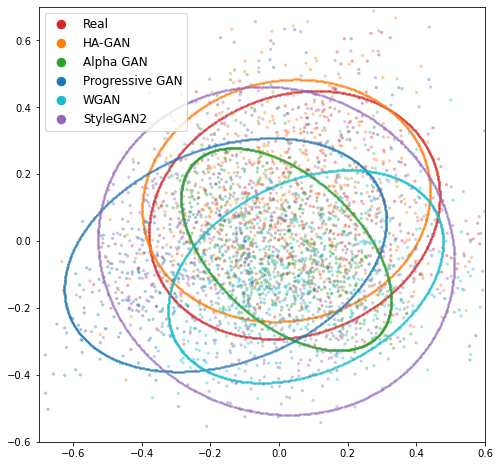

In [24]:
colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:cyan', 'tab:purple', 'tab:olive', 'tab:pink']
models_bak = ["Real", "HA-GAN", "Alpha GAN", "VAE-GAN", "Progressive GAN", "WGAN", "CCE-GAN", "StyleGAN2"]
models = ["Real", "HA-GAN", "Alpha GAN", "Progressive GAN", "WGAN", "StyleGAN2"]

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(6):
    ax.scatter(pred_arr_list_mds[512*i:512*(i+1),0], pred_arr_list_mds[512*i:512*(i+1),1],
               c=colors[i], s=10, label=models[i],
               alpha=0.4, edgecolors='none')
    fit = fit_eclipse(pred_arr_list_mds[512*i:512*(i+1),0].copy(), pred_arr_list_mds[512*i:512*(i+1),1].copy())
    ax.scatter(fit[0, :], fit[1, :], c=colors[i], s=2.5, alpha=0.4)

ax.legend()
#ax.grid(True)

plt.xlim(-0.7, 0.6)
plt.ylim(-0.6, 0.7)

leg = plt.legend(prop={'size': 12}, markerscale=3.,)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.savefig("./results/MDS_COPD.pdf", bbox_inches='tight')
plt.show()